In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
df = pd.read_csv(dataset)

### <a name='C2'> EDA et Choix des features   </a>

In [5]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

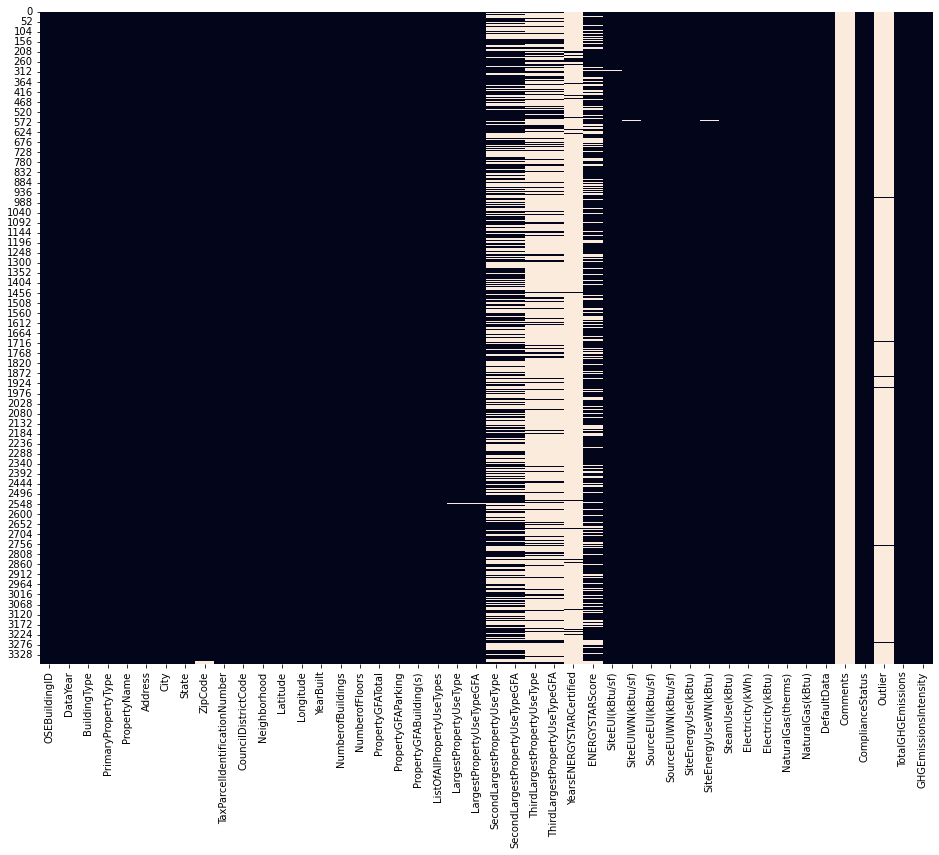

In [8]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

- Typologie des variables

In [9]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Nombre de variables différentes par Feature

In [10]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [11]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [12]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [13]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [14]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [15]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [16]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA'] # Réflechir sur rajouter ou non Campus comme building résidentiel,'Campus','SPS-District K-12',

nonResidential = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [17]:
compliant = ['Compliant']

nonResidential = nonResidential[nonResidential['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [18]:
nonResidential.shape

(1432, 46)

In [19]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
Medical Office                  38
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [20]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)

In [21]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Residence Hall'].index)

In [22]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
K-12 School                     38
Medical Office                  38
Self-Storage Facility           28
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [23]:
nonResidential.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        633
SecondLargestPropertyUseTypeGFA     633


In [24]:
nonResidential['ComplianceStatus'].value_counts()

Compliant    1410
Name: ComplianceStatus, dtype: int64

In [25]:
nonResidential['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [26]:
nonResidential = nonResidential[nonResidential.Outlier.isnull()]

In [27]:
nonResidential = nonResidential[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions']]

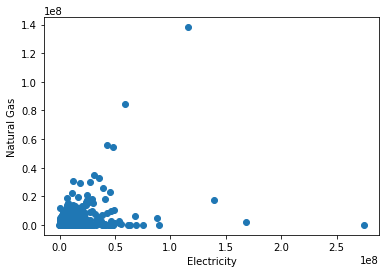

In [28]:
plt.scatter(nonResidential['Electricity(kBtu)'],nonResidential['NaturalGas(kBtu)'])
plt.xlabel('Electricity')
plt.ylabel('Natural Gas')
plt.show()

In [29]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
dtype: int64

In [30]:
nonResidential = nonResidential.dropna(axis=0) 

In [31]:
nonResidential['NumberofBuildings'].value_counts()

1.0    1329
0.0      44
2.0      11
3.0      10
6.0       4
5.0       3
4.0       2
9.0       1
7.0       1
8.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [32]:
df1 = nonResidential.copy()

In [33]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [34]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [35]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [36]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [37]:
train, test = train_test_split(df2_code, test_size=0.3, random_state=0) 

In [38]:
X_train, y_train, X_test, y_test = train.drop(columns = "TotalGHGEmissions"), train["TotalGHGEmissions"],test.drop(columns = "TotalGHGEmissions") ,test["TotalGHGEmissions"]

In [39]:
r_forest = RandomForestRegressor(random_state=0)

In [40]:
# entrainement du modèle
r_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [41]:
# prédiction
preds = r_forest.predict(X_test)

# calcul du RMSE
print(m_s_e(y_test,preds, squared=False))

225.28196282908175


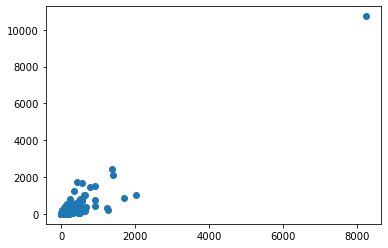

In [42]:
plt.scatter(preds,y_test)

In [43]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [44]:
def get_dummy_error(strategy, X_train, X_test, y_train, y_test):
    model = DummyRegressor(strategy=strategy)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [45]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for strategy in ['mean', 'median']:
    my_rmse = get_dummy_error(strategy, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("strategy: %s  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(strategy, my_rmse[0], my_rmse[1], my_rmse[2]))

strategy: mean  		 RMSE:  580.784464  		 MAE: 186.041318  		 R2:  -0.000272
strategy: median  		 RMSE:  592.373010  		 MAE: 140.880142  		 R2:  -0.040587


In [46]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  225.281963  		 MAE: 93.918171  		 R2:  0.849498
N_Estimator: 200  		 RMSE:  247.327951  		 MAE: 96.410227  		 R2:  0.818601
N_Estimator: 300  		 RMSE:  246.105985  		 MAE: 96.628927  		 R2:  0.820389
N_Estimator: 400  		 RMSE:  250.427385  		 MAE: 96.689883  		 R2:  0.814026
N_Estimator: 500  		 RMSE:  252.698587  		 MAE: 97.167913  		 R2:  0.810638


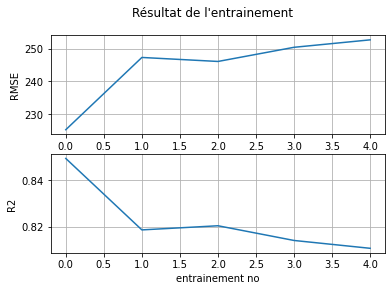

In [47]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

### - Dummy Regressor

In [48]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [49]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [50]:
CV_dummy_mean.best_score_

-0.0037899037977626284

In [51]:
dummy_model = CV_dummy_mean.best_estimator_

In [52]:
dummy_model.score(X_test,y_test)

-0.0002718438953386304

In [53]:
pd.DataFrame(CV_dummy_mean.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_strategy,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.001197,0.000401,0.000797,0.000399,mean,{'strategy': 'mean'},-0.003262,-0.001102,-0.001170,-0.013402,...,259359.677374,1,-925.709043,-375.583289,-494.640353,-439.713799,-617.251663,-570.579629,194.530918,1
1,0.000996,0.000001,0.000998,0.000631,median,{'strategy': 'median'},-0.033283,-0.136560,-0.052199,-0.037387,...,264376.949807,2,-939.457154,-400.187254,-507.089270,-444.886881,-630.632358,-584.450583,193.689543,2


### - Random Forest Regressor


In [54]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [55]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [56]:
CV_rfc.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 12}

In [57]:
CV_rfc.best_score_

0.6074766656519976

In [58]:
model = CV_rfc.best_estimator_

In [59]:
model.score(X_test,y_test)

0.780987580384676

In [60]:
pd.DataFrame(model.feature_importances_)

,0
0,0.048303
1,0.061858
2,0.148728
3,0.047227
4,0.167477
5,0.007502
6,0.180036
7,0.028273
8,0.000292
9,0.009629


In [61]:
pd.DataFrame(CV_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_r2,...,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.187290,0.006617,0.008448,0.000618,4,auto,100,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.648306,...,82893.887292,59,-548.087136,-388.863129,-312.854020,-236.616034,-408.280553,-378.940174,104.109133,65
1,0.386914,0.020215,0.015755,0.000857,4,auto,200,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.636476,...,83580.194736,69,-557.229412,-392.126936,-326.451310,-252.145078,-411.594930,-387.909533,101.446643,75
2,0.591961,0.021724,0.022384,0.000853,4,auto,300,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.635130,...,87692.910559,60,-558.260061,-388.673937,-324.887825,-219.154707,-396.931187,-377.581544,110.469785,62
3,0.780462,0.019011,0.028711,0.000501,4,auto,400,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.637670,...,87683.112186,57,-556.313284,-389.665314,-319.322280,-215.914651,-398.587389,-375.960584,111.399719,60
4,0.989209,0.006008,0.037617,0.005425,4,auto,500,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.635325,...,88885.319168,56,-558.110638,-389.635295,-324.482432,-207.287668,-390.892322,-374.081671,113.729062,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.192846,0.007848,0.011569,0.000797,64,log2,100,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.551305,...,124422.528217,22,-619.074448,-311.756410,-318.406529,-128.914512,-375.869187,-350.804217,157.738107,13
71,0.362600,0.010339,0.021476,0.002423,64,log2,200,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.586127,...,113464.048909,5,-594.566727,-315.010722,-319.642883,-121.280286,-383.310159,-346.762155,151.873990,5
72,0.584412,0.010231,0.032533,0.002166,64,log2,300,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.583226,...,113379.858979,13,-596.647344,-311.581177,-330.430164,-133.917057,-389.358652,-352.386879,148.933779,17
73,0.768778,0.015250,0.041127,0.002074,64,log2,400,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.576470,...,115023.308981,40,-601.463493,-311.315856,-340.329087,-135.907245,-393.741656,-356.551467,149.905510,31


### - Ridge Regressor

In [62]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [63]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [64]:
CV_ridge.best_score_

0.4753206706337553

In [65]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=0.1)


In [66]:
model_ridge.score(X_test,y_test)

0.7494712500432306

In [67]:
pd.DataFrame(CV_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,split5_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.003566,0.000722,0.002011,0.000569,0.001,{'alpha': 0.001},0.702682,-0.015387,0.078840,0.645664,...,3,-541.454766,-433.682092,-224.913333,-343.683786,-189.606619,-392.409126,-354.291620,120.248528,3
1,0.002989,0.000137,0.002169,0.000378,0.01,{'alpha': 0.01},0.702801,-0.013417,0.077958,0.645560,...,2,-541.346934,-433.261248,-225.020951,-343.734109,-189.618770,-392.615087,-354.266183,120.162453,2
2,0.003490,0.000750,0.002170,0.000386,0.1,{'alpha': 0.1},0.703618,0.005394,0.069082,0.644418,...,1,-540.601652,-429.221394,-226.101442,-344.287221,-189.767424,-394.632439,-354.101929,119.411114,1
3,0.002747,0.000563,0.002078,0.000732,1,{'alpha': 1},0.701344,0.125474,-0.016371,0.629265,...,4,-542.671752,-402.478013,-236.251083,-351.546441,-191.823526,-411.949871,-356.120114,116.512089,4
4,0.002829,0.000373,0.002490,0.000496,2,{'alpha': 2},0.694752,0.180949,-0.097151,0.612179,...,5,-548.628132,-389.503424,-245.460063,-359.556130,-194.243450,-426.633204,-360.670734,116.535500,5
5,0.003160,0.000687,0.002411,0.000446,5,{'alpha': 5},0.676310,0.211230,-0.265514,0.574373,...,6,-564.958534,-382.235535,-263.621602,-376.674033,-199.911907,-453.756731,-373.526390,119.296536,6
6,0.003158,0.000895,0.002493,0.000499,10,{'alpha': 10},0.655848,0.185983,-0.420691,0.542131,...,7,-582.541679,-388.304653,-279.317043,-390.680365,-205.036895,-475.080714,-386.826891,122.960711,7


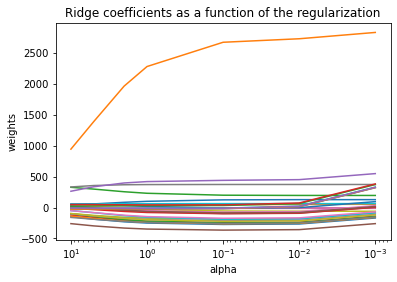

In [68]:
alphas = [1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### - KNN Regressor

In [69]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [72]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [73]:
CV_knn.best_score_

0.26514108758037963

In [74]:
model_knn = CV_knn.best_estimator_

In [75]:
model_knn.score(X_test,y_test)

0.3184745882722346

In [76]:
CV_knn.best_params_

{'n_neighbors': 12}

In [77]:
pd.DataFrame(CV_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,split5_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.002497,0.000497,0.006742,0.001463,10,{'n_neighbors': 10},0.183391,0.244643,0.332690,0.349194,...,90,-897.343510,-374.051875,-191.430689,-465.775977,-332.824281,-643.365570,-484.131984,229.899160,5
1,0.003380,0.001415,0.007483,0.001354,11,{'n_neighbors': 11},0.172325,0.256752,0.346346,0.350234,...,89,-903.403527,-371.041701,-189.461684,-465.403479,-331.607412,-627.118150,-481.339326,230.731220,2
2,0.002658,0.000751,0.005949,0.000572,12,{'n_neighbors': 12},0.177491,0.263492,0.365132,0.370390,...,87,-900.579727,-369.355522,-186.719414,-458.128243,-337.628964,-627.150675,-479.927091,230.052235,1
3,0.001672,0.000462,0.004976,0.000470,13,{'n_neighbors': 13},0.168085,0.276268,0.190026,0.355392,...,85,-905.714392,-366.137746,-210.903144,-463.552676,-334.108274,-613.164566,-482.263467,225.782878,3
4,0.001728,0.000530,0.005042,0.000879,14,{'n_neighbors': 14},0.160374,0.207034,0.217769,0.323976,...,88,-909.901955,-383.250737,-207.259801,-474.714310,-334.748958,-614.671800,-487.424594,226.382743,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.002129,0.000245,0.006364,0.000436,95,{'n_neighbors': 95},0.098013,0.250714,0.438135,0.171209,...,5,-943.087072,-372.545682,-175.656304,-525.622242,-350.777094,-619.949188,-497.939597,243.261142,86
86,0.002497,0.001135,0.006983,0.001390,96,{'n_neighbors': 96},0.097316,0.248909,0.437978,0.171452,...,3,-943.451761,-372.994223,-175.680798,-525.545156,-351.162406,-620.219007,-498.175558,243.310740,87
87,0.002159,0.000355,0.006097,0.000704,97,{'n_neighbors': 97},0.096374,0.248305,0.438516,0.170562,...,4,-943.943918,-373.144029,-175.596740,-525.827316,-351.507025,-620.558348,-498.429563,243.465551,88
88,0.002165,0.000676,0.006212,0.000526,98,{'n_neighbors': 98},0.095453,0.249215,0.436098,0.171975,...,2,-944.424914,-372.918194,-175.974439,-525.379360,-351.910712,-620.612494,-498.536685,243.503911,89


### - XGBoost

In [78]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [79]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [80]:
CV_xgboost.best_score_

0.6164486610259905

In [81]:
model_boosted = CV_xgboost.best_estimator_

In [82]:
model_boosted.score(X_test,y_test)

0.8634272464462868

In [83]:
pd.DataFrame(CV_xgboost.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_r2,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.183878,0.006028,0.002464,0.000481,4,auto,100,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.680765,...,20.090081,51,-522.182801,-419.351027,-318.395864,-379.768569,-416.739163,-411.287485,66.354816,51
1,0.372728,0.007503,0.002763,0.000732,4,auto,200,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.681753,...,20.764012,52,-521.374388,-422.196911,-317.009402,-386.905233,-419.582212,-413.413629,65.980592,52
2,0.557108,0.019517,0.003250,0.000385,4,auto,300,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.682297,...,20.665017,53,-520.928405,-422.992689,-315.587601,-390.001784,-419.747052,-413.851506,66.042994,53
3,0.749416,0.006833,0.003069,0.000766,4,auto,400,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.682122,...,20.067760,54,-521.071505,-422.677060,-315.139128,-390.842416,-419.870418,-413.920105,66.157047,54
4,0.936331,0.012938,0.004244,0.000718,4,auto,500,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.682404,...,19.816759,56,-520.840259,-422.633002,-314.841006,-391.376661,-420.492882,-414.036762,66.145056,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.177382,0.003358,0.005585,0.000798,64,log2,100,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.609641,...,29.382082,29,-577.430215,-331.607925,-366.187200,-135.693036,-339.711461,-350.125967,140.255514,29
71,0.350438,0.004581,0.007924,0.000169,64,log2,200,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.609651,...,29.382099,27,-577.422401,-331.608260,-366.182238,-135.695501,-339.707545,-350.123189,140.252163,27
72,0.399663,0.004736,0.009066,0.000690,64,log2,300,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.609651,...,29.382099,21,-577.422401,-331.608260,-366.182238,-135.695501,-339.707545,-350.123189,140.252163,21
73,0.429864,0.025235,0.009489,0.001911,64,log2,400,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.609651,...,29.382099,21,-577.422401,-331.608260,-366.182238,-135.695501,-339.707545,-350.123189,140.252163,21
